# **Introduction**

Hello,

Welcome to an example of a Kinetic Monte Carlo (KMC) system using an arbitrary 2D vacancy defect. The process here is informed by the chapter 'Introduction to the kinetic monte carlo method' by A. F. Voter from the textbook *Radiation Effects in Solids*

Credit is given where possible in the code comments. If you find something missing attributation, please inform me and I will endeavour to correct it ASAP.

I hope this notebook proves informative,

Christoff Reimer

# **Initial imports**

In [1]:
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML, Image
from matplotlib.colors import ListedColormap
from copy import deepcopy

# **Class to create synthetic system**

Note 1: The time units used here are arbitrary.

Note 2: The system is programmed to treat diagonals and cartesian axis directions equally for transitions. Feel free to alter this to fit your design if a purely up/down/left/right setup is better.

In [2]:
# Creates a dynamic 2D defect migration spin system on a grid and allows for interactions with it
class sys_dynamics:

  # Initialize system with required characteristics such as size, region of interest, where we want the defect, and random generator objects
  def __init__(self, components, s_x, s_y, vac_idx, rng_traj, rng_system, rng_rate, roi_x = 1, roi_y = 1):
    '''
    inputs:
    * s_x, s_y
    * vac_idx
    * rng_traj
    * rng_system
    * rng_rate
    * roi_x, roi_y
    Outputs:
    * None
    Class Variables:
    * components (int) --> number of different components/elements in system
    * ssize (tuple) --> System size
    * vx, vy (int) --> defect location
    * v_idx (tuple) --> 2D position of defect
    * rng_s (generator) --> numpy random number generator for creating system
    * rng_rate (generator) --> for initial rates
    * rng_t (generator) --> "  " for picking trajectory next item
    * arr (2D np array) --> 2D system of integer spins from 1-5
    * roi_x, roi_y (int) --> Size of the ROI, in neighbours along x and along y (i.e. a value of 1 for each creates a 3x3 matrix around the defect)
    * rate_constants (np array) --> Randomly generated migration rate constants from a narrow range
    * rates (np array) --> final rates for migration to each atom type (scaled in ns)
    '''
    self.ssize = (s_x, s_y)
    self.vx = vac_idx[0]
    self.vy = vac_idx[1]
    self.v_idx = vac_idx
    self.rng_s = rng_system
    self.rng_t = rng_traj
    # Create our 2D system
    self.arr = self.rng_s.integers(1, components, size=(s_x, s_y), dtype=np.int64, endpoint=True)
    self.roi_x = roi_x
    self.roi_y = roi_y

    # Generate migration rate constants
    self.rate_constants = rng_rate.uniform(0.5, 2, components)
    print("The rate constants for this arbitrary system are:", self.rate_constants)

  # Introduce a defect to the system
  def add_v(self):
    self.arr[self.vx][self.vy] = 0

  # Credit to Alexander McFarlane
  # https://stackoverflow.com/questions/38066785/np-ndarray-with-periodic-boundary-conditions
  def latticeWrapIdx(self, index, lattice_shape):
    """returns periodic lattice index
    for a given iterable index

    Required Inputs:
        index :: iterable :: one integer for each axis
        lattice_shape :: the shape of the lattice to index to
    """
    # if not hasattr(index, '__iter__'): return index         # handle integer slices
    # if len(index) != len(lattice_shape): return index  # must reference a scalar
    # if any(type(i) == slice for i in index): return index   # slices not supported
    pbc_data = []
    for ix in index:
      if len(ix) == len(lattice_shape):               # periodic indexing of scalars
          mod_index = tuple(( (i%s + s)%s for i,s in zip(ix, lattice_shape)))
          pbc_data.append(mod_index)
      else:
        raise ValueError('Unexpected index: {}'.format(index))
    return pbc_data

  # Extract our Region of Interest (ROI)
  def sys_cutter(self):
    '''
    inputs:
    * None
    Outputs:
    * None
    Class Variables:
    * pos (list of tuples) --> Positions for the atoms in the ROI, in (x, y) format
    * roi (np 2D array) --> Small matrix of the ROI
    '''
    # Positions
    self.pos = [(self.vx + i, self.vy + j) for i in range(-self.roi_x, self.roi_x + 1) for j in range(-self.roi_y, self.roi_y + 1)]
    # Check for PBCs in position data
    self.pos = self.latticeWrapIdx(self.pos, self.ssize)
    # Get ROI atom types from positions
    self.roi = [self.arr[p[0], p[1]] for p in self.pos]
    # Get ROI atom types in matrix shape
    self.roi = np.reshape(self.roi, (1 + (2*self.roi_x), 1 + (2*self.roi_x)))

  def sys_rules(self, roi_flattened = np.zeros(9)):
    '''
    inputs:
    * roi_flattened (1D np array) --> Atom types from ROI in flattened form
    Outputs:
    * None
    Class Variables:
    * R (float) --> sum of the rates present in a given ROI configuration
    * rate_set (1D np array) --> rates present in a given ROI configuration
    * vx, vy (int) --> defect location
    '''

    # For making a trajectory
    # Stores the rates for each atom type found in the ROI
    self.rate_set = []
    # Loop over positions data (excluding defect) and get data on type of atom present
    for i in self.pos:
      a = self.arr[i[0], i[1]]
      self.rate_set.append(self.rate_constants[a-1])
    # Sum of rates in ROI
    self.R = np.sum(self.rate_set)
    # List of rates in ROI, scaled by R to range (0,1]
    self.prob_vec = self.rate_set/self.R

  def trajectory_gen(self, T):
    '''
    inputs:
    * T (int) --> Time alloted for simulation, in ns
    Outputs:
    * None
    Class Variables:
    * times (list of floats) --> Residence times (in ns)
    * coord_path (list of tuples) --> defect positions
    * evolve (list of 2D np arrays) --> State of the system at a given timestep
    '''

    # Create lists to fill later
    self.times = []

    # Add a defect to our system
    self.add_v()
    # Excise the ROI from the system
    self.sys_cutter()

    # Start filling our system information lists for the coordinate path and the system state
    self.coord_path = [self.v_idx]
    self.evolve = [deepcopy(self.arr)]

    # Init time variable
    t = 0

    # Use system rules according to rote
    self.sys_rules()

    # TODO delete this
    print(self.arr)
    print("The first rate set is:",self.rate_set, "for", self.roi)
    print("This is for position", self.pos)
    print(self.roi)

    #dt = np.random.exponential(scale = 1/self.R, size = 1)[0]

    # This is the time snippet we take for each step...
    dt = (-1/self.R) * np.log(self.rng_t.random(1))[0]

    # Loop until we run out of time, updating and evolving our system
    while t + dt < T:

      # Save our residence times
      self.times.append(dt)
      # Get an index tuple for the chosen position in the ROI, using prob_vec as our p distribution
      chosen = self.rng_t.choice(9, replace=False, p = self.prob_vec)

      # Get position tuple of chosen jump
      chosen_pos = self.pos[chosen]

      # Change the spot we are vacating with the spot we are moving to/swapping with
      # TODO I think that the vx and vy may be backwards, but that it doesn't affect anything.  Check up on this
      self.arr[self.vx,self.vy] = self.arr[chosen_pos[0], chosen_pos[1]]
      self.arr[chosen_pos[0], chosen_pos[1]] = 0
      self.vx = chosen_pos[0]
      self.vy = chosen_pos[1]

      # Update our defect index
      self.v_idx = (self.vx, self.vy)
      # Update our evolving system with the new system frame
      self.evolve.append(deepcopy(self.arr))
      # Update our coordinates for the defect movement with our defect index
      self.coord_path.append(self.v_idx)

      # Increment our running time
      t += dt

      # Cut new ROI from system
      self.sys_cutter()
      # Get new Ktotal (we call it R here) and rate vector
      self.sys_rules()

      # Pick new timestep
      dt = (-1/self.R) * np.log(self.rng_t.random(1))[0]

    # Take care of our final time steps and state
    self.times.append(T - t)

# **(Pseudo)randomly generate a system and defect trajectory**

In [3]:
# Give in some rng generators
rng_sys = np.random.default_rng(1234)
rng_traj = np.random.default_rng(5678)
rng_rate = np.random.default_rng(9101)

sys = sys_dynamics(3, 21,21,(10,10), rng_traj, rng_sys, rng_rate)
sys.add_v()
T_time = 10
sys.trajectory_gen(T_time)


The rate constants for this system (in ns) are: [0.84340772 0.89199655 1.33298616]
[[3 3 3 2 1 3 1 1 1 1 2 1 3 1 3 1 3 3 3 1 2]
 [2 1 2 3 3 2 3 2 3 3 2 1 3 3 1 3 1 3 3 2 1]
 [1 3 1 3 1 2 2 1 1 3 2 2 2 2 1 1 2 1 2 3 2]
 [2 1 3 3 3 3 1 3 3 2 1 3 3 3 1 3 2 2 3 3 1]
 [3 3 3 3 1 3 2 2 3 2 3 2 1 1 3 1 3 2 1 3 1]
 [2 2 1 3 3 2 3 1 2 1 2 3 3 1 3 2 1 1 3 2 3]
 [3 3 1 1 2 2 3 2 3 1 1 2 1 2 2 3 3 1 2 1 2]
 [1 1 2 3 1 3 1 3 1 1 3 2 2 2 1 1 1 1 3 2 1]
 [2 3 1 1 3 3 1 2 3 1 3 1 3 3 2 2 3 1 1 1 2]
 [2 3 3 2 2 3 3 1 3 2 1 2 1 1 2 2 1 2 1 2 2]
 [2 3 1 3 1 1 2 2 3 1 0 1 1 3 3 1 1 3 1 1 2]
 [2 3 2 1 3 1 1 2 3 3 3 2 1 3 3 3 1 1 2 3 1]
 [2 1 2 2 3 3 2 3 3 3 3 2 1 3 3 2 3 1 3 1 1]
 [3 2 3 1 1 3 3 1 2 1 3 3 1 3 2 1 2 2 1 3 1]
 [1 2 1 1 3 1 2 2 2 2 2 1 3 3 3 3 2 3 2 3 1]
 [1 3 1 2 1 3 1 1 2 3 3 2 1 1 3 3 3 3 1 1 1]
 [3 2 1 1 1 1 2 1 1 2 2 2 3 3 3 1 2 3 3 2 3]
 [2 3 1 2 3 1 3 3 2 1 3 2 1 1 3 3 2 1 1 1 3]
 [2 3 3 2 1 2 1 2 1 1 2 1 3 1 2 1 3 3 3 3 1]
 [1 3 3 3 1 3 3 1 3 3 1 3 1 2 2 3 3 2 3 1 3]
 [3 3 3 2 2 1 2 1

# **Save animated section of system movement**

This section makes and saves a '.gif' format view of the system evolving over time. The readme file of the tutorial github for this notebook has a playing example of the output.

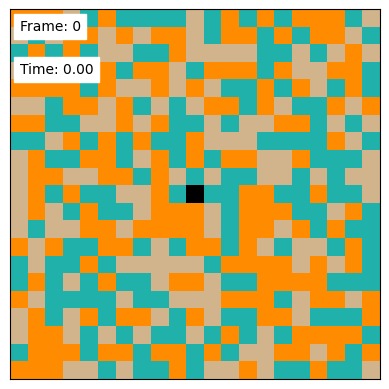

In [4]:
rc('animation', html='jshtml')
fig = plt.figure()
im = plt.imshow(sys.evolve[0], animated=True, aspect = "equal", cmap = ListedColormap(["black", "turquoise", "lightseagreen", "crimson", "tan", "darkorange"]))
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)
frame_text = im.axes.text(0.05, 0.05,'',horizontalalignment='left',verticalalignment='top', backgroundcolor = 'white')
time_text = im.axes.text(0.05, 2.5,'',horizontalalignment='left',verticalalignment='top', backgroundcolor = 'white')

# Creates each updated frame of the gif output based on the system data saved earlier
def updatefig(j):

    text_frame = "Frame: " + str(j)
    text_time = "Time: " + str("{:.2f}".format(float(np.sum(sys.times[:j]))))

    im.set_array(sys.evolve[j])
    frame_text.set_text(text_frame)
    time_text.set_text(text_time)

    return im, frame_text, time_text

ani = animation.FuncAnimation(fig, updatefig, frames = len(sys.evolve), repeat_delay = 1000, repeat = True, blit=True)

plt.show()

ani.save("ani.gif", writer="pillow", fps = 4)